In [12]:
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split
from torchvision import datasets
from torchvision.transforms import ToTensor, Normalize, Compose, Resize, ConvertImageDtype
from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score
from pathlib import Path

for module in np, pd, torch:
    print(module.__name__, module.__version__)

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)
print(torch.cuda.get_device_name())

numpy 2.0.2
pandas 2.2.3
torch 2.6.0+cu126
cuda:0
NVIDIA GeForce GTX 1050 Ti


In [13]:
in_size = 5
out_size = 5
kernel_size = 3
stride = 1
padding = 0

print((in_size + 2 * padding -kernel_size)//stride + 1)

def get_padding(in_size, out_size, kernel_size, stride)->int:
    padding = ((out_size - 1) * stride + kernel_size - in_size) / 2
    return int(padding) if padding.is_integer() else int(padding) + 1 

3


In [14]:
DATA_DIR = Path("./archive/")

class MonkeyDataset(datasets.ImageFolder):
    def __init__(self, mode, transform = None):
        if mode == "train":
            root = DATA_DIR / "training"
        elif mode == "valid":
            root = DATA_DIR / "validation"
        
        super().__init__(root, transform)

        self.imgs = self.samples    # (img_path, label)
        self.targets = [s[1] for s in self.samples]

In [15]:
img_h, img_w = 128, 128

transform = Compose([
    Resize((img_h, img_w)),
    ToTensor(),
    Normalize([0.4363, 0.4328, 0.3291], [0.2085, 0.2032, 0.1988]),
    ConvertImageDtype(torch.float),
])

train_datasets = MonkeyDataset("train", transform=transform)
valid_datasets = MonkeyDataset("valid", transform=transform)

print(len(train_datasets), len(valid_datasets))

1097 272


In [16]:
batch_size = 16
train_dataloader = DataLoader(train_datasets, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_datasets, batch_size=batch_size, shuffle=False)

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.activation = F.relu
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding="same")
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding="same")
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding="same")
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding="same")
        self.conv5 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding="same")
        self.conv6 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding="same")
        self.pool  = nn.MaxPool2d(2, 2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 16 * 16, 128)
        self.fc2 = nn.Linear(128, 10)
        self.init_weights()

    def init_weights(self):
        for m in self.modules():
            if isinstance(m, (nn.Linear, nn.Conv2d)):
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        act = self.activation
        x = self.pool(act(self.conv2(act(self.conv1(x)))))
        x = self.pool(act(self.conv4(act(self.conv3(x)))))
        x = self.pool(act(self.conv6(act(self.conv5(x)))))
        x = self.flatten(x)
        x = self.fc2(act(self.fc1(x)))
        return x
    
for idx, (key, value) in enumerate(CNN().named_parameters()):
    print(f"{key}\tparamerters num: {np.prod(value.shape)}")

conv1.weight	paramerters num: 864
conv1.bias	paramerters num: 32
conv2.weight	paramerters num: 9216
conv2.bias	paramerters num: 32
conv3.weight	paramerters num: 18432
conv3.bias	paramerters num: 64
conv4.weight	paramerters num: 36864
conv4.bias	paramerters num: 64
conv5.weight	paramerters num: 73728
conv5.bias	paramerters num: 128
conv6.weight	paramerters num: 147456
conv6.bias	paramerters num: 128
fc1.weight	paramerters num: 4194304
fc1.bias	paramerters num: 128
fc2.weight	paramerters num: 1280
fc2.bias	paramerters num: 10


In [18]:
@torch.no_grad()
def evaluating(model, data_loader, loss_function):
    loss_list = []
    pred_list = []
    label_list = []

    for imgs, labels in data_loader:
        imgs = imgs.to(device)
        labels = labels.to(device)
        logits = model(imgs)
        loss = loss_function(logits, labels)
        pred = logits.argmax(axis = -1)

        loss_list.append(loss.item())
        pred_list.extend(pred.cpu().numpy().tolist())
        label_list.extend(labels.cpu().numpy().tolist())
    
    acc = accuracy_score(label_list, pred_list)
    return np.mean(loss_list), acc

In [19]:
class EarlyStopCallBack:
    def __init__(self, patience = 5, min_delta = 0.01):
        self.patience = patience
        self.min_delta = min_delta
        self.best_metric = -1
        self.counter = 0
    
    def __call__(self, metric):
        if metric >= self.best_metric + self.min_delta:
            self.best_metric = metric
            self.counter = 0
        else:
            self.counter += 1
    
    @property
    def early_stop(self):
        return self.counter >= self.patience

In [20]:
def training(model,
             train_dataloader,
             valid_dataloader,
             epoch,
             loss_function,
             optimizer,
             early_stop_cb=None,
             eval_step = 500
):
    record_dict = {"train":[], "valid":[]}
    global_step = 0
    model.train()
    with tqdm(total=epoch*len(train_dataloader)) as pbar:
        for epoch_id in range(epoch):
            for imgs, labels in train_dataloader:
                imgs = imgs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                logits = model(imgs)
                loss = loss_function(logits, labels)
                loss.backward()
                optimizer.step()
                preds = logits.argmax(axis=-1)
                acc = accuracy_score(labels.cpu().numpy(), preds.cpu().numpy())
                loss = loss.cpu().item()

                record_dict["train"].append({
                    "loss":loss, "acc":acc, "step":global_step
                })

                if global_step % eval_step == 0:
                    model.eval()
                    valid_loss, valid_acc = evaluating(model, valid_dataloader, loss_function)
                    record_dict["valid"].append({
                        "loss":valid_loss, "acc":valid_acc, "step":global_step
                    })
                    model.train()
                
                    if early_stop_cb is not None:
                        early_stop_cb(valid_acc)
                        if early_stop_cb.early_stop:
                            print(f"Early Stop at epoch : {epoch_id} / global_step : {global_step}")
                            return record_dict
                
                global_step += 1
                pbar.update(1)
                pbar.set_postfix({"epoch":epoch_id})
                
    return record_dict

In [27]:
epoch = 20
model = CNN().to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, eps=1e-7)
early_stop_cb = EarlyStopCallBack()

record = training(model, train_dataloader, valid_dataloader, epoch, loss_function, optimizer, early_stop_cb, eval_step=len(train_dataloader))

  0%|          | 0/1380 [00:00<?, ?it/s]

Early Stop at epoch : 13 / global_step : 897


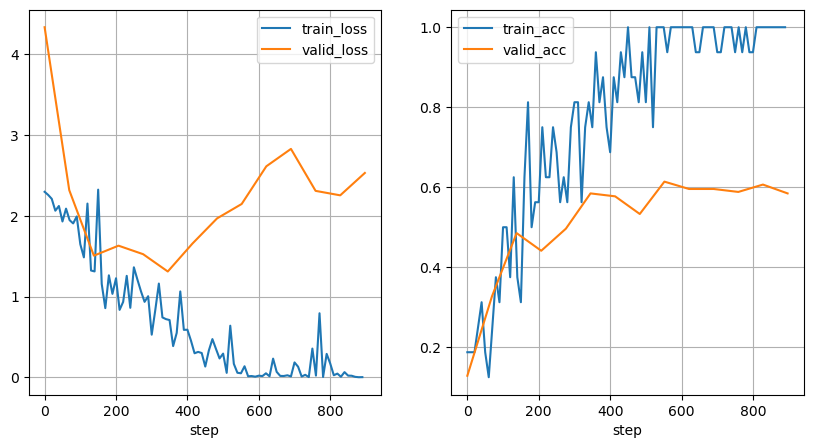

In [28]:
def plot_learning_curve(record_dict, sample_step = 500):
    train_df = pd.DataFrame(record_dict["train"]).set_index("step").iloc[::sample_step]
    valid_df = pd.DataFrame(record_dict["valid"]).set_index("step")
    fig_num = len(train_df.columns)
    fig, axs = plt.subplots(1, fig_num, figsize=(5 * fig_num, 5))
    for idx, item in enumerate(train_df.columns):    
        axs[idx].plot(train_df.index, train_df[item], label=f"train_{item}")
        axs[idx].plot(valid_df.index, valid_df[item], label=f"valid_{item}")
        axs[idx].grid()
        axs[idx].legend()
        axs[idx].set_xlabel("step")
    
    plt.show()

plot_learning_curve(record, sample_step=10)

In [30]:
model.eval()
loss, acc = evaluating(model, valid_dataloader, loss_function)
print(f"loss: {loss:.4f}, acc: {acc:.4f}")

loss: 2.5312, acc: 0.5846
